In [1]:
from river.datasets import synth
from river import tree, stream, metrics, drift,forest
from itertools import chain
from itertools import cycle
import itertools
import random
import pickle
import helper_lib
import importlib
from helper_lib import group_close_numbers, transform_drift_detections_into_intervals
from helper_lib import take_tests_for_streams_on_tree, prefix_sum, take_tests_for_streams_on_given_model
from helper_lib import take_tests_for_streams_on_given_model_experimental, visualize_interval_differences, visualize_results
from helper_lib import take_tests_for_streams_on_given_model_detectors_dynamic_pool
from helper_lib import take_tests_for_streams_on_given_model_fast_detectors_dynamic_pool
from helper_lib import calculate_drift_intervals
from complex_generators import generate_cyclical_drift_stream, generate_random_chain_stream
from model_factory import ARFModelFactory,TreeModelFactory

In [4]:
generator_pool_size=5
number_of_generators=20
number_of_features=5
samples_per_generator = [random.randint(5000, 20000) for _ in range(number_of_generators)]
width=[random.randint(50, int(min([samples_per_generator[i],samples_per_generator[i+1]])/10)) for i in range(number_of_generators-1)]
seed=1
classifier_names = [
        # "hoeffding_tree",
        "adaptive_rf",
        # "naive_bayes",
        # "logistic_regression",
        # "knn",
    ]
chained_generator, drift_widths = generate_cyclical_drift_stream(
    generator_pool_size=generator_pool_size,
    number_of_generators=number_of_generators,
    number_of_features=number_of_features,
    samples_per_generator=samples_per_generator,
    width=width,
    seed=1,
    generators_active=[0,1,2]
)

1
13326
Synthetic data generator

    Name  RandomTree                
    Task  Multi-class classification
 Samples  ∞                         
Features  5                         
 Outputs  1                         
 Classes  2                         
  Sparse  False                     

Configuration
-------------
                seed_tree  16543
              seed_sample  66864
                n_classes  2    
           n_num_features  5    
           n_cat_features  0    
 n_categories_per_feature  2    
           max_tree_depth  6    
         first_leaf_level  3    
fraction_leaves_per_level  0.15 
2
24304
Synthetic data generator

    Name  RandomTree                
    Task  Multi-class classification
 Samples  ∞                         
Features  5                         
 Outputs  1                         
 Classes  2                         
  Sparse  False                     

Configuration
-------------
                seed_tree  30911 
              seed_sample

In [3]:
def ADWIN_detector_factory():
    return drift.ADWIN()
def KSWIN_detector_factory():
    return drift.KSWIN()
def DDM_detector_factory():
    return drift.binary.DDM()
def HDDM_A_detector_factory():
    return drift.binary.HDDM_A()
def HDDM_W_detector_factory():
    return drift.binary.HDDM_W()


all_samples_number = sum(samples_per_generator)
metric = metrics.ClassificationReport()
number_of_detectors = 50

In [ ]:
from model_factory import ModelFactoryProducer
result_per_classifier = {}

for classifier_name in classifier_names:
    detected_change_points, accuracys_windowed,binary_accuracy = take_tests_for_streams_on_given_model_fast_detectors_dynamic_pool(
            chained_generator,
            all_samples_number,
            metric,
            detector_factories = {
                "ADWIN": ADWIN_detector_factory,
                #KSWIN": KSWIN_detector_factory,
                # "DDM": DDM_detector_factory,
                # "HDDM_A": HDDM_A_detector_factory,
                # "HDDM_W": HDDM_W_detector_factory,
            },
            model_factory=ModelFactoryProducer.get_factory(classifier_name),
            number_of_detectors=number_of_detectors,
            detector_offset=80
        )
    result_per_classifier[classifier_name] = (detected_change_points, accuracys_windowed,binary_accuracy)

with open('experiment_9_2.pkl', 'wb') as file:
    pickle.dump(result_per_classifier, file)

In [2]:
# Deserialize the object from the file
with open('experiment_9.pkl', 'rb') as file:
    result_per_classifier= pickle.load(file)

adaptive_rf


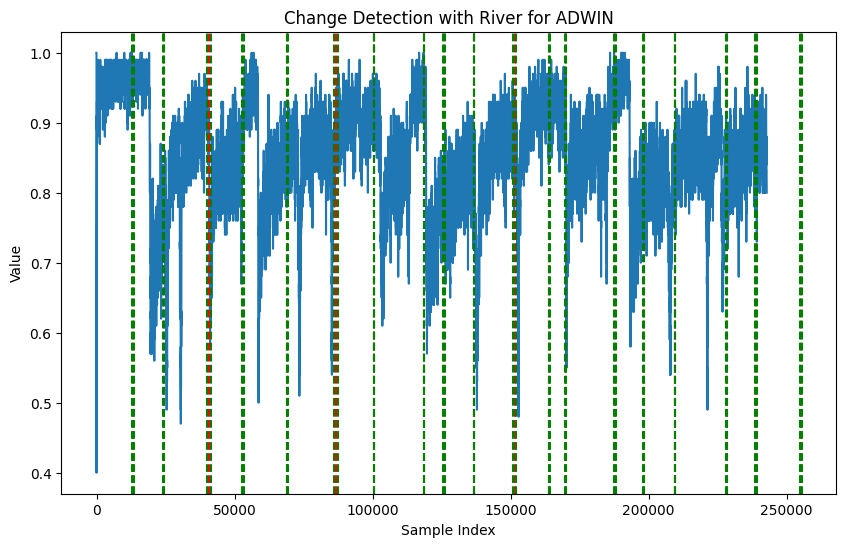

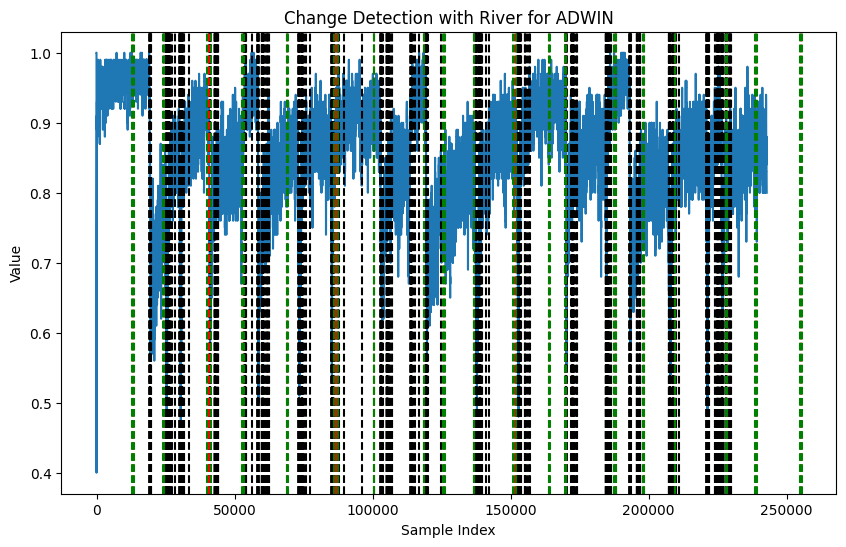

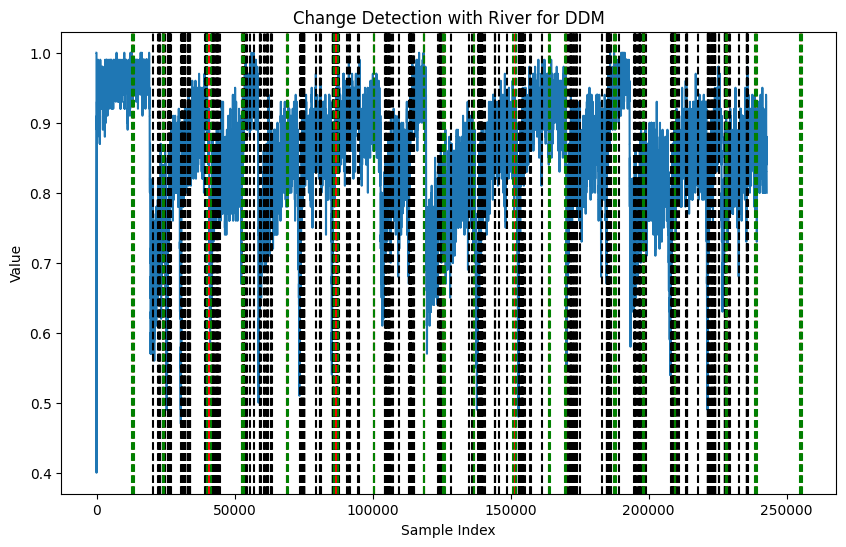

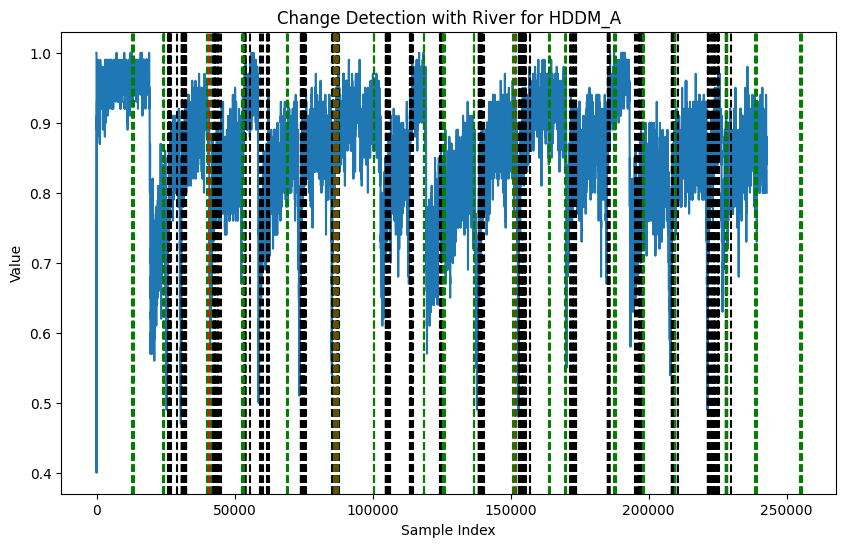

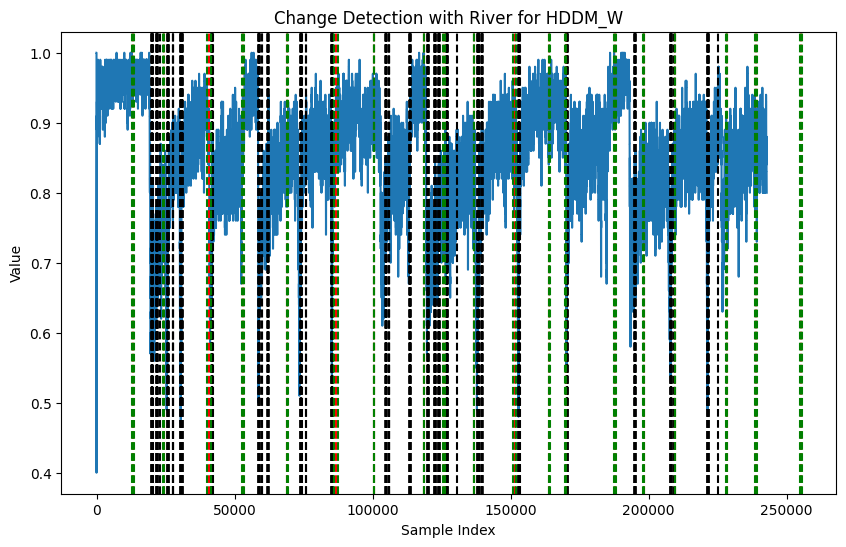

In [5]:
for name in classifier_names:
    print(name)
    (detected_change_points, accuracys_windowed,binary_accuracy) = result_per_classifier[name]
    true_drift_points = prefix_sum(samples_per_generator)
    visualize_results({"ADWIN":[]}, true_drift_points,drift_widths, accuracys_windowed)
    visualize_results(detected_change_points, true_drift_points,drift_widths, accuracys_windowed)

hoeffding_tree


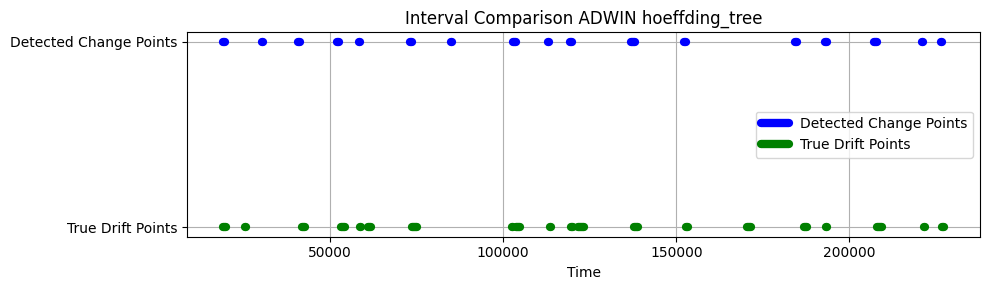

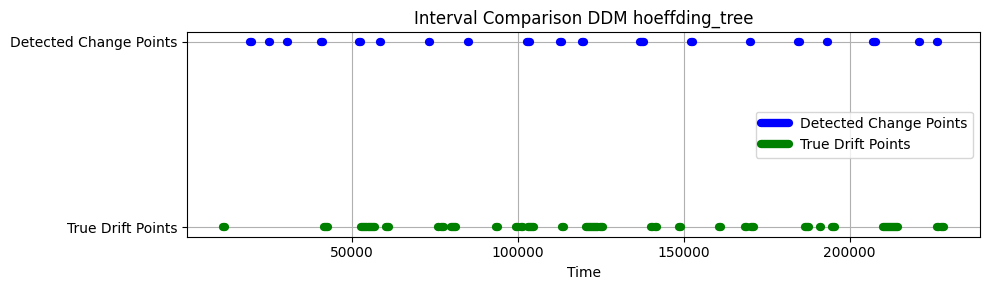

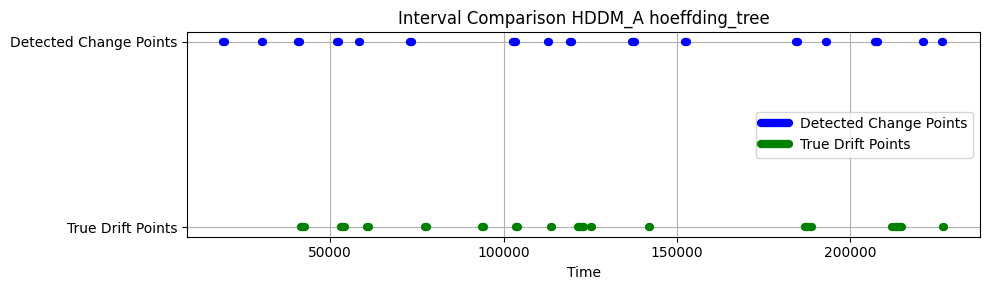

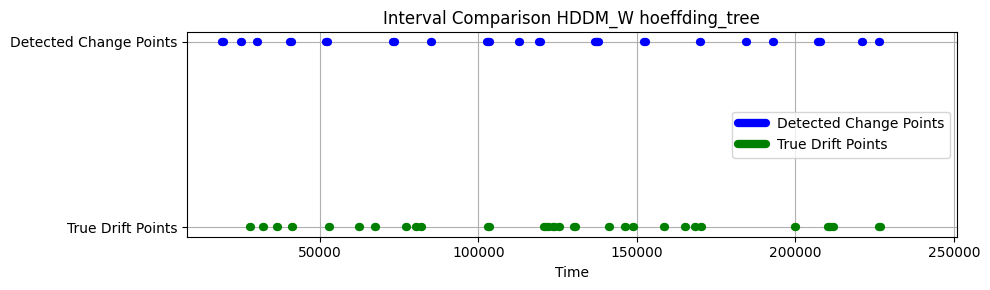

adaptive_rf


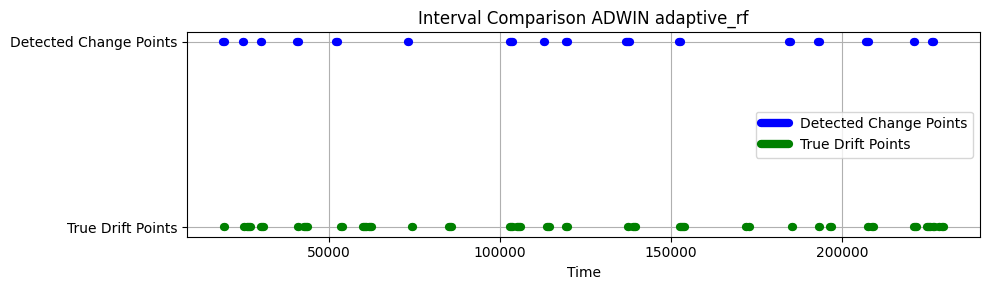

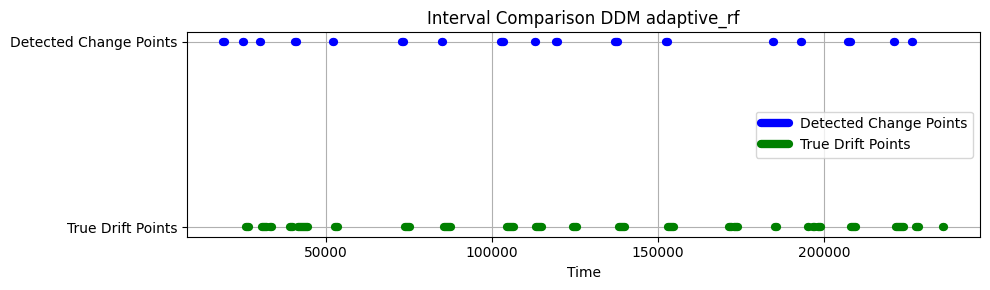

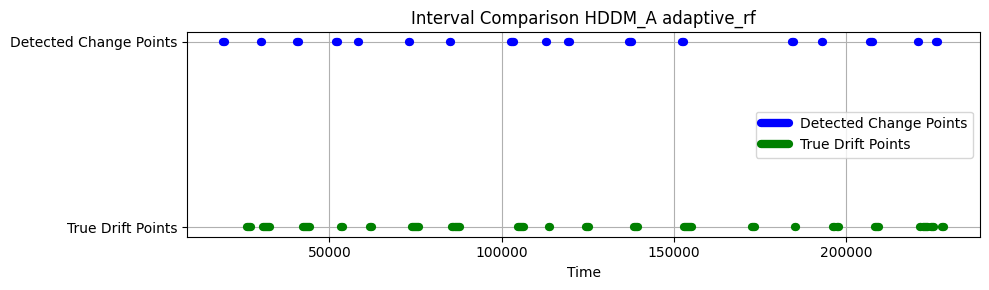

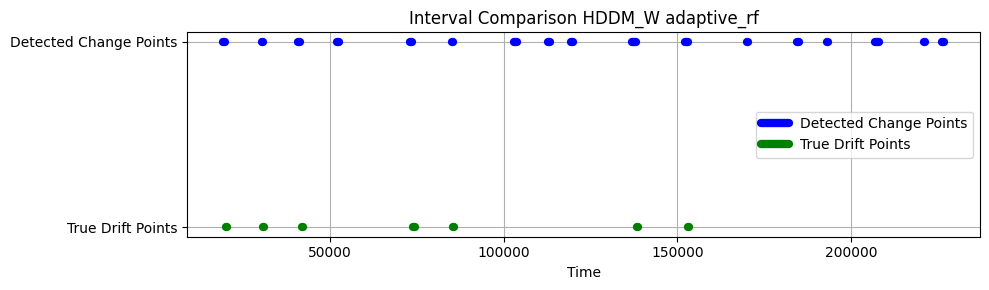

naive_bayes


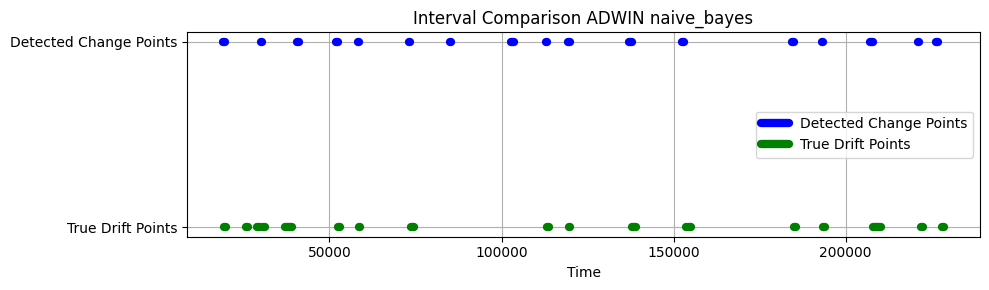

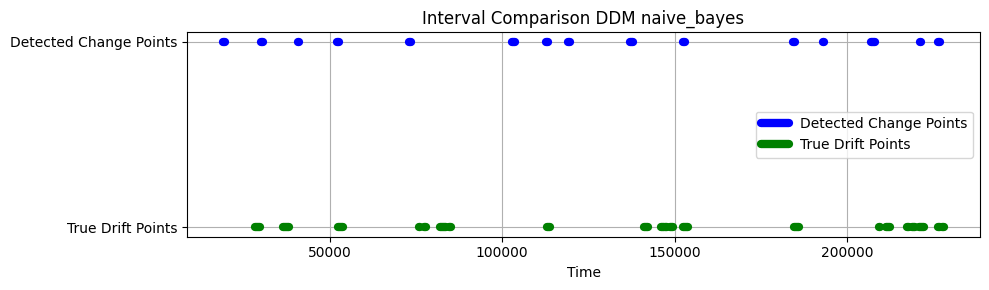

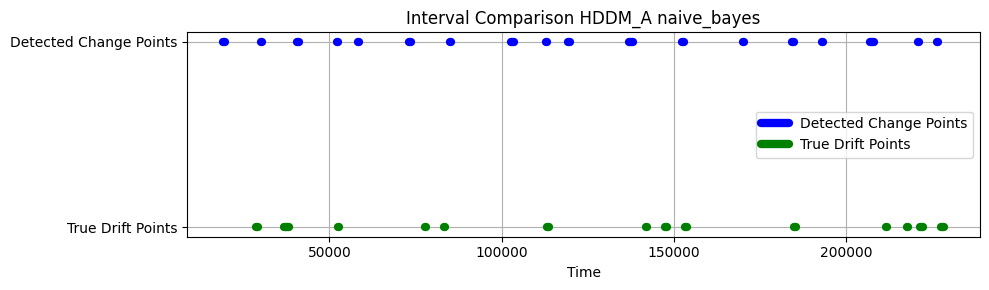

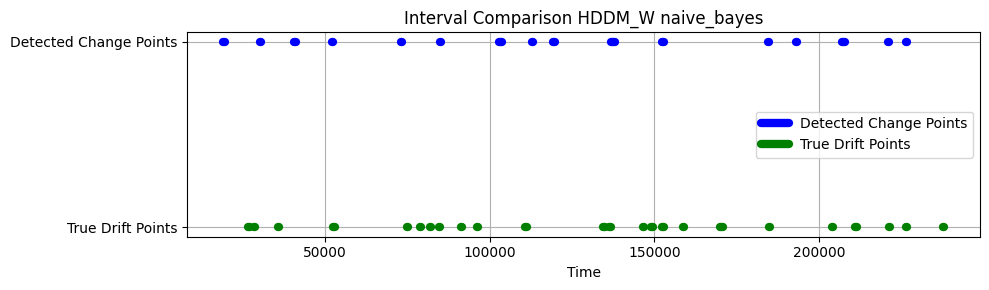

logistic_regression


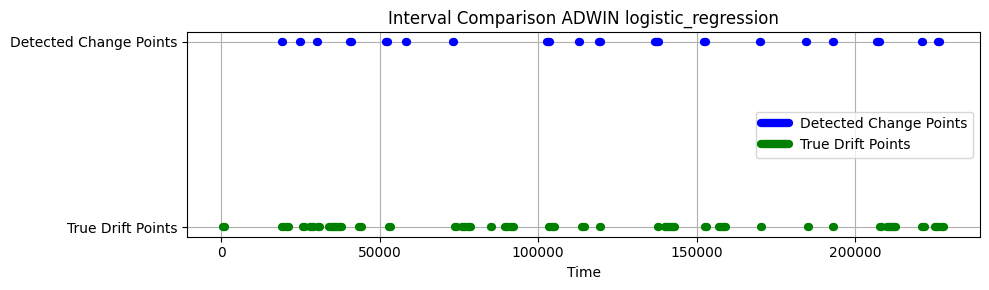

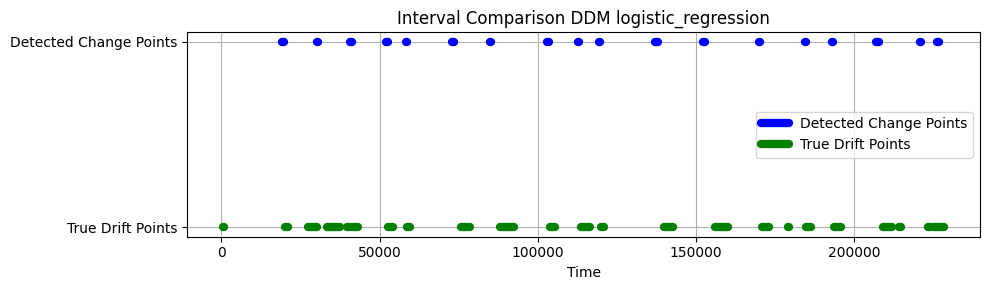

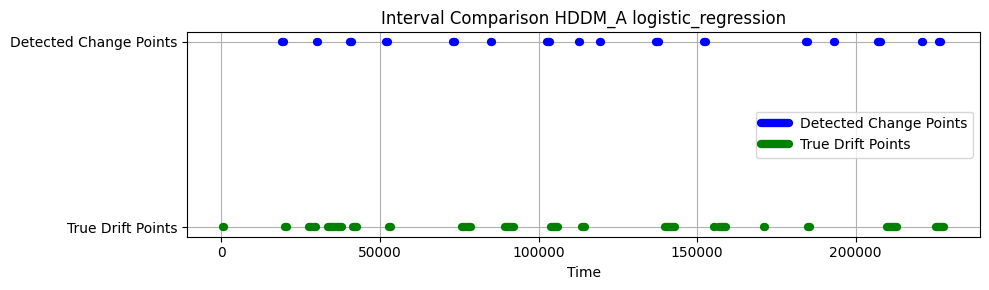

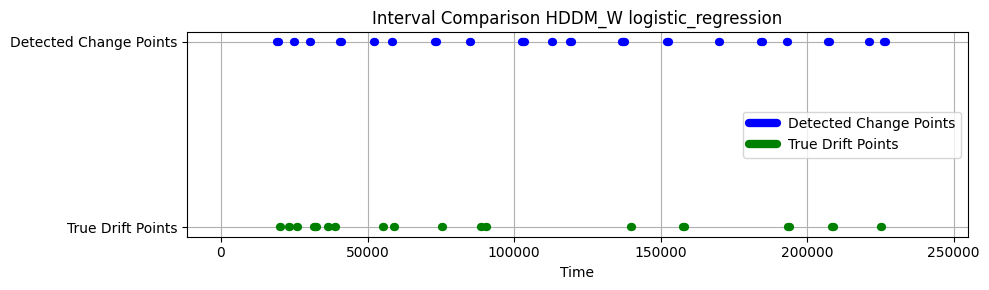

knn


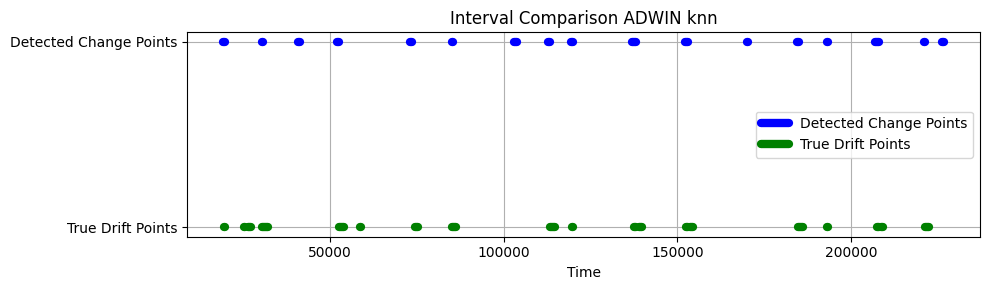

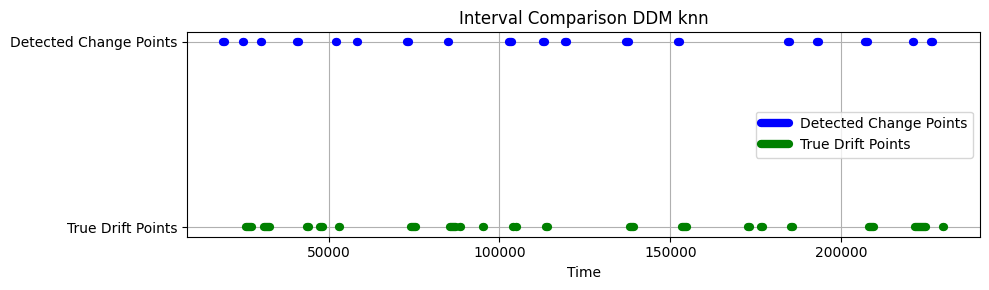

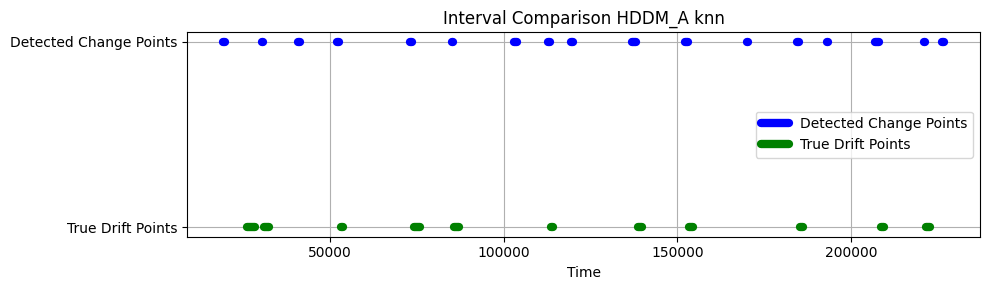

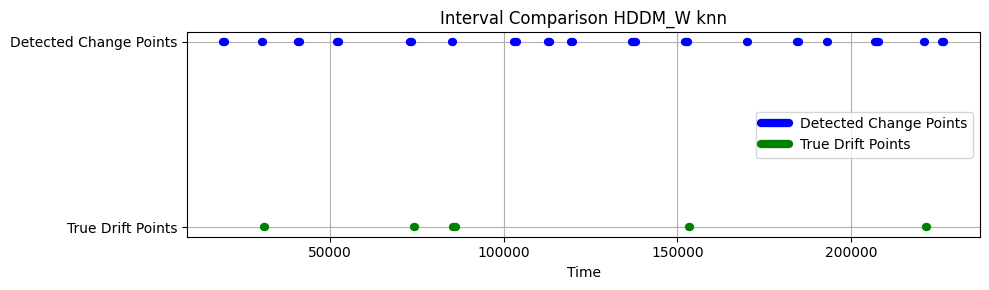

In [7]:
importlib.reload(helper_lib)

for classifier_name in classifier_names:
    print(classifier_name)
    intervals_a = calculate_drift_intervals(true_drift_points,drift_widths)
    (detected_change_points, accuracys_windowed,binary_accuracy) = result_per_classifier[classifier_name]
    for name,detected_point in detected_change_points.items():
        intervals_b = transform_drift_detections_into_intervals(detected_change_points[name],500,4)
        helper_lib.visualize_interval_differences(intervals_a, intervals_b, labels=('Detected Change Points', 'True Drift Points'),name=name+ " " +classifier_name)

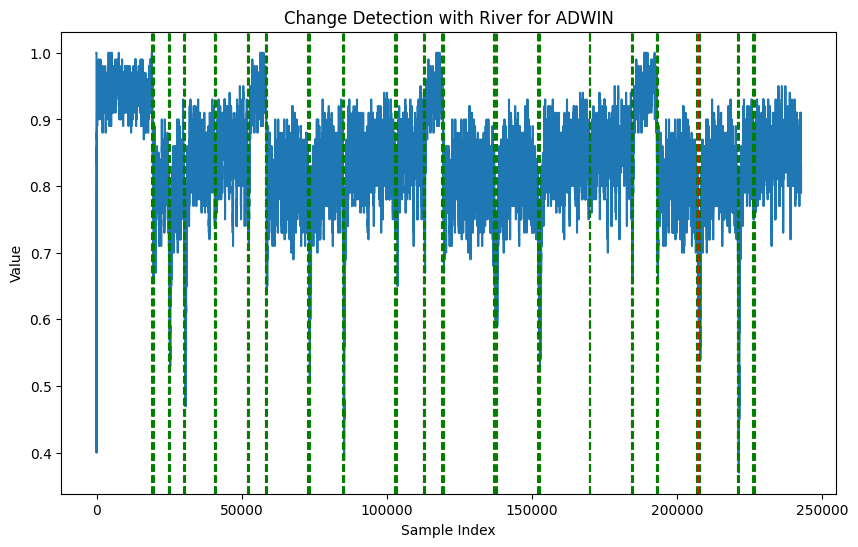

hoeffding_tree


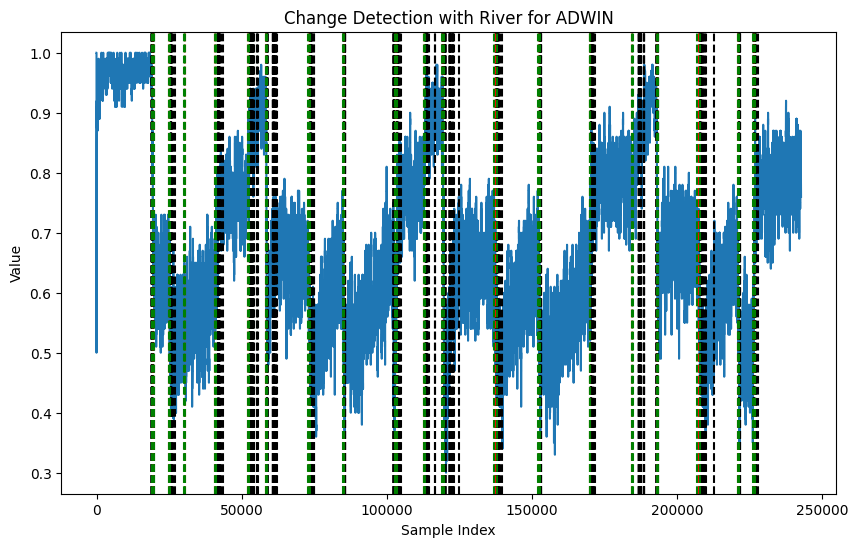

adaptive_rf


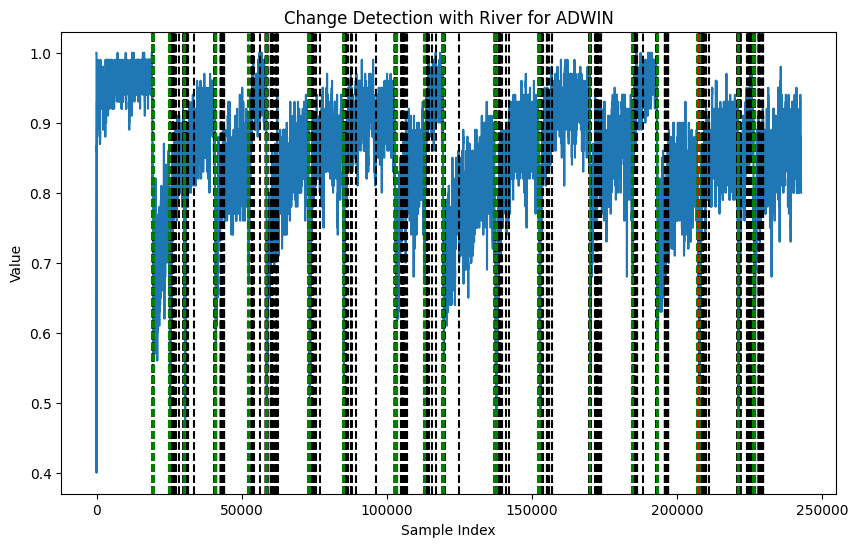

naive_bayes


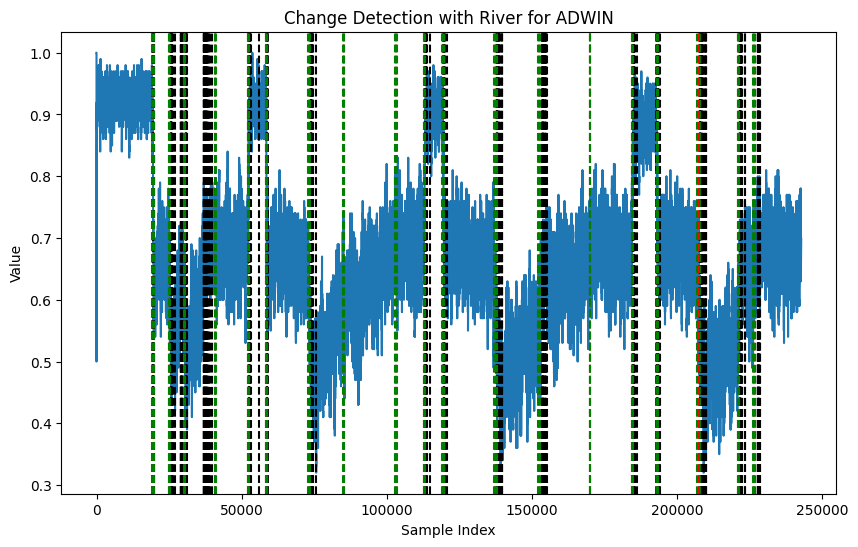

logistic_regression


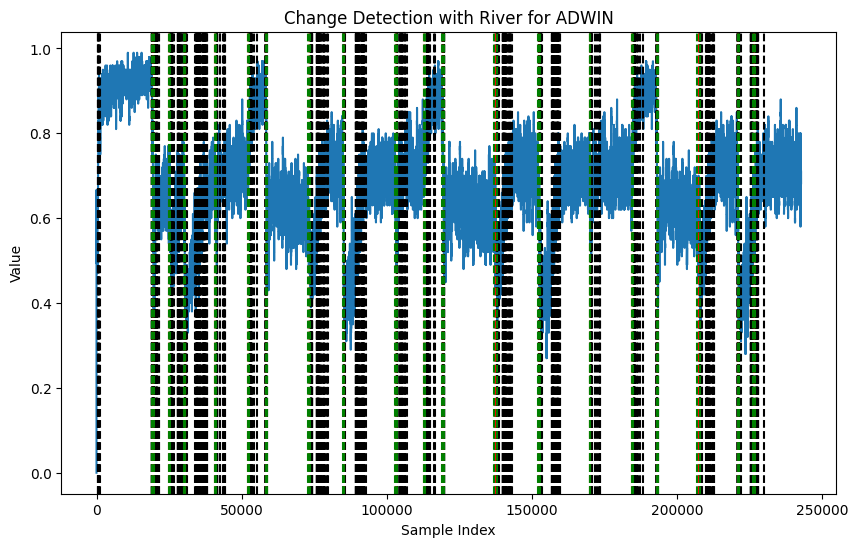

knn


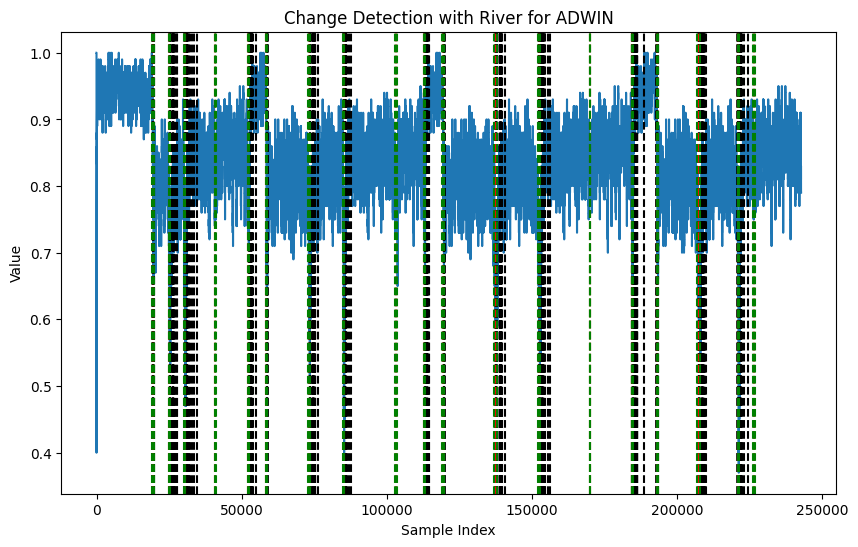

In [8]:
visualize_results({"ADWIN":[]}, true_drift_points,drift_widths, accuracys_windowed)
for name in classifier_names:
    print(name)
    (detected_change_points, accuracys_windowed,binary_accuracy) = result_per_classifier[name]
    true_drift_points = prefix_sum(samples_per_generator)
    visualize_results({"ADWIN":detected_change_points['ADWIN']}, true_drift_points,drift_widths, accuracys_windowed)

hoeffding_tree


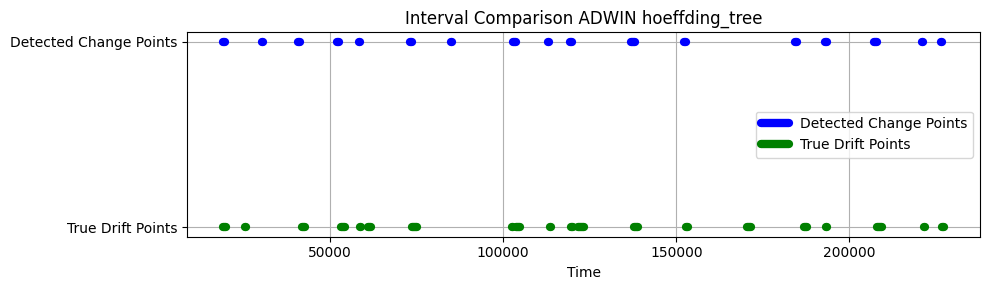

adaptive_rf


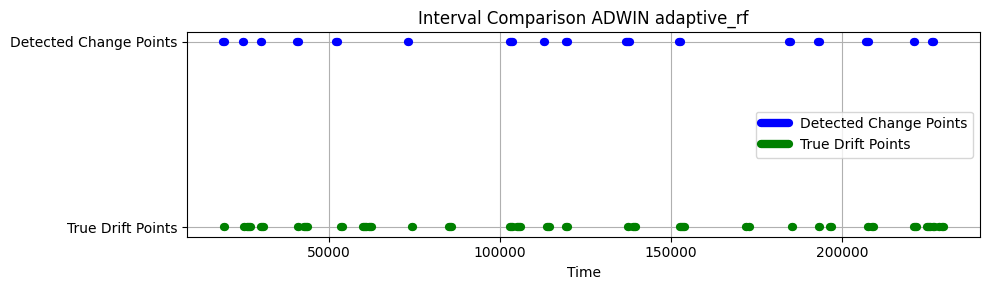

naive_bayes


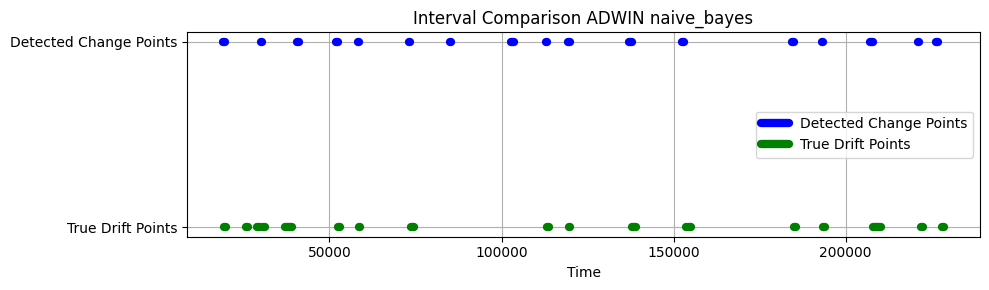

logistic_regression


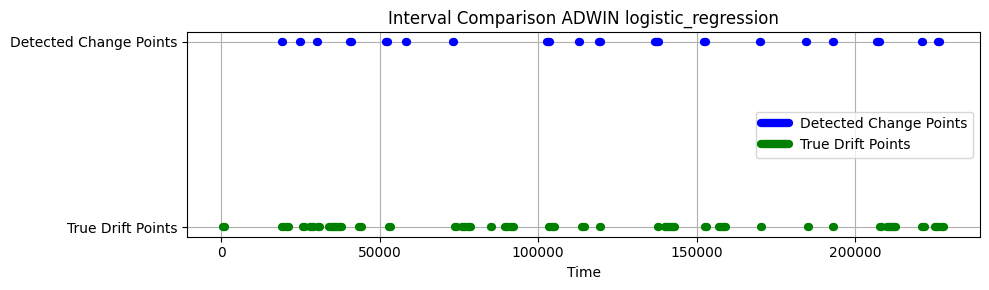

knn


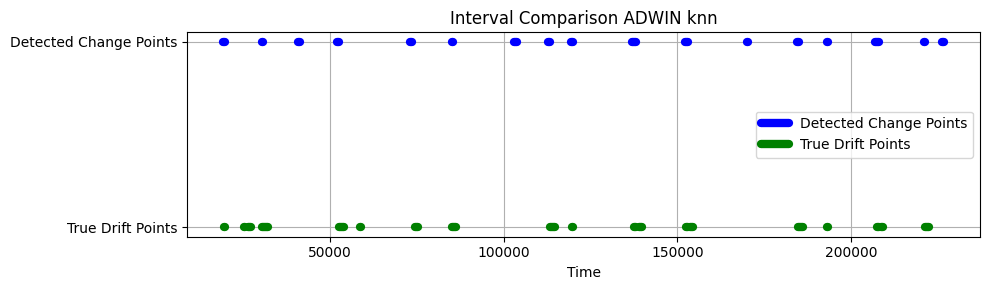

In [9]:
for classifier_name in classifier_names:
    print(classifier_name)
    intervals_a = calculate_drift_intervals(true_drift_points,drift_widths)
    (detected_change_points, accuracys_windowed,binary_accuracy) = result_per_classifier[classifier_name]
    for name,detected_point in detected_change_points.items():
        if name=='ADWIN':
            intervals_b = transform_drift_detections_into_intervals(detected_change_points[name],500,4)
            helper_lib.visualize_interval_differences(intervals_a, intervals_b, labels=('Detected Change Points', 'True Drift Points'),name=name+ " " +classifier_name)

In [15]:
import dice
import importlib
importlib.reload(dice)
dice_coefficients= {}
for classifier_name in classifier_names:
    print(classifier_name)
    intervals_a = calculate_drift_intervals(true_drift_points,drift_widths)
    (detected_change_points, accuracys_windowed,binary_accuracy) = result_per_classifier[classifier_name]
    for DD_name,detected_point in detected_change_points.items():
        intervals_b = transform_drift_detections_into_intervals(detected_change_points[DD_name],120,6)
        dice_coefficients[classifier_name+ " " + DD_name]=dice.dice_coefficient(intervals_a, intervals_b)


adaptive_rf


In [16]:

sorted_dict = dict(sorted(dice_coefficients.items(), key=lambda item: item[1],reverse=True))
for name,value in sorted_dict.items():
    print(f"{name}: {value}")

adaptive_rf DDM: 0.09276980329611909
adaptive_rf ADWIN: 0.03310741918071133
adaptive_rf HDDM_A: 0.0254633963677214
adaptive_rf HDDM_W: 0.0


C:\Users\1234o\AppData\Local\Temp\ipykernel_22068\1019451932.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['samples of generators', 'drift length'])


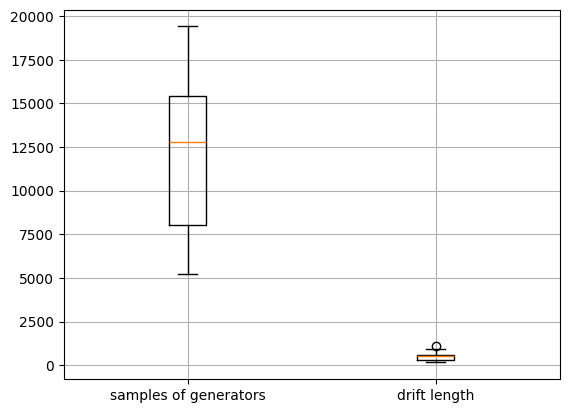

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example data — replace with your own
data = [
    samples_per_generator,
    width
]

plt.boxplot(data, labels=['samples of generators', 'drift length'])
plt.title('')
plt.grid(True)
plt.show()